# Manifesto map

## Overview
It is useful to map out texts, for example, books and articles, so that text that are close in meaning are close in the map.  This might help identify hidden connections between the maps.  

This notebook maps texts based on simularities between the words that they contain.  The texts were featured in the 2015 film installation [Manifesto](https://en.wikipedia.org/wiki/Manifesto_\(2015_film\)) written, produced and directed by Julian Rosefeldt, in which Cate Blanchett reads out a series of manifestos.  The manifestos are grouped into a number of classifications, for example, Situationism, Futurism and Dadaism.  The aim of the work is to map out the different manifestos, and see how that mapping corresponds to the mappings given.

A key part of this process is **vectorisation** of a text string.  This means counting the words in a text string and turning these into a vector.  For example in the document "the stupid dog jumped over the stupid fox" can be represented as the vector [2,2,1,1,1,1] where each number represents the number of times the word occurs.  The set of all the words in each document is the **vocabulary**.

## Processing flow

### File preparation - manual processing
Each text mentioned in the [Manifesto](https://en.wikipedia.org/wiki/Manifesto_\(2015_film\)) film available on the web as a text, PDF or other readable file was scraped into a `.txt` file and saved in the `data` directory.  An index file [index.csv](data/index.csv) was also created and saved with information linking the file name to the text's Title, Author, Year, Category and a link to the source.

### Read in files and cleanse files
The files are then read in and cleansed to remove non text strings.  This is done using the [re](https://docs.python.org/3/library/re.html) regular expressions module by replacing strings `'<.*?>'` or `'[^a-zA-Z0-9\s]'`, with the empty string `''`, noting that `[ ]` signifiers a range of charactors, and `^` signifies inverting a string.  The line feeds are stripped out of the file, so that each file was transformed into a long text string, containing the files words and spaces.

### Combine files
The text strings for each file, are combined into a python list `corpus`.

### Vectorisation
Next the corpus is vectorised, meaning that a new vector matrix is created, as described above.  In the **bag of words** approach the words are simply counted.  A flaw with this is that because words like 'and', 'the' are prevalent in each document, each vector is fairly similar, and analysis is more challenging.  A more advanced approach is [tf–idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) short for **term frequency–inverse document frequency**.  

Here the term frequency $tf(t, d)$ is the relative frequency of a term t in a document d, and the inverse document frequency is is a measure of how much information the word provides, i.e., how common or rare it is across all documents.  It is the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient).  Then:
$${\displaystyle \mathrm {tfidf} (t,d,D)=\mathrm {tf} (t,d)\cdot \mathrm {idf} (t,D)}$$

### Feature matrix processing and plotting.
The feature matrix was normalised, and a simularity matrix was produced.  The simularity matrix is plotted and [saved](plot/Simularity_matrix.png)

### Scatter map processing and plotting
Principal Component Analysis (PCA) was used to find the main two components of the feature vector.  Then a scatter plot showing the manifesto map is plotted and [saved](plot/Manifesto_map.png)

### Ward cluster processing and Dendogram plotting
Ward clustering to produce a Dendogram, which is plotted and [saved](plot/Dendogram.png)


Import packages and modules needed.

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize

from text_functions import read_index, read_text_files
from text_functions import tokenize

from clustering_functions import calculate_simularity_matrix, pca_reduction

from plot_functions import plot_matrix, plot_dendogram, plot_scatter

import pprint

Set constants to control subsequent processing:

In [2]:
PATH_DATA = 'data/'         #path for data
PATH_PLOT = 'plot/'         #path for plots
INDEX_FILE = 'index.csv'    #location of index file 
ENCODING = 'utf-8-sig'      #Encoding of files
METHOD = 'Tfidf'            #'Tfidf' for Term Frequency - Inverse Document Frequency 
                            # or 'Count' for naive methods
MAX_DF=0.8                  #default 1.0
MIN_DF=2                    #default 1
STEM = True                 #stem words?
PCA_COMPONENTS = 2          #number of PCA components to keep (only two are plotted)
OFFSET = 0                  #Offset for annotations on scatter plot
ANNOTATE_PLOT = False       #Annotate scatter plot
VERBOSE = False             #Add more information?

Read in the next file and store as a dictionary `index_dict`.  Use this read the text files, and assemnle into a `corpus` list.

In [3]:
index_filename = PATH_DATA + INDEX_FILE
index_dict = read_index(index_filename, ENCODING)
if VERBOSE:
    pprint.pp(index_dict)
corpus = read_text_files(index_dict, ENCODING, PATH_DATA)

Define a vectoriser and use it to produce a feature matrix `X` based on the word frequencies in the documents.

In [4]:
if METHOD == 'Tfidf':
    if STEM:
        vectorizer = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF, tokenizer=tokenize)
    else:
        vectorizer = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF)
elif METHOD == 'count':
    if STEM:
        vectorizer = CountVectorizer(tokenizer=tokenize)
    else:
        vectorizer = CountVectorizer()
else:
    raise Exception('Unknown methods')

# Fit the vectorizer to the documents and transform the documents into a document-term matrix
X = vectorizer.fit_transform(corpus)

# Get the feature names (tokens)
feature_names = vectorizer.get_feature_names_out()

c:\Users\DanielGoldsmith\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [5]:
print(f'There are {len(feature_names)} features')

There are 2351 features


Normalise the matrix and use it to calculate the simularity matrix.

In [6]:
normalised_matrix = normalize(X, norm='l2', axis=1)
simularity_matrix = calculate_simularity_matrix(normalised_matrix)

Plot out the simularity matrix.  Lighter colours mean that the documents are more similar.

c:\Users\DanielGoldsmith\Desktop\python notebooks\little_magazines\plot_functions.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


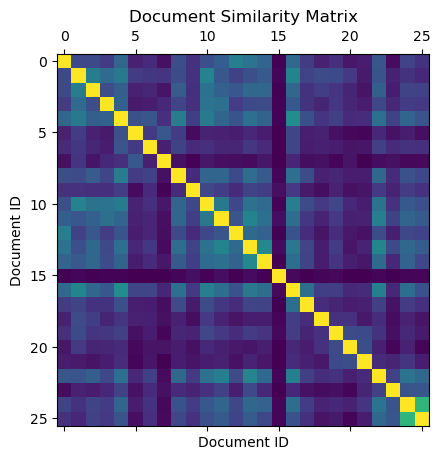

In [7]:
plot_matrix(simularity_matrix, PATH_PLOT)

Run principal component analysis to find the two principal components.

In [8]:
x, y = pca_reduction(simularity_matrix, PCA_COMPONENTS)

Plot out the two principle components of each manifesto.  This is a manifesto map, were more similar manifestos are closer together.

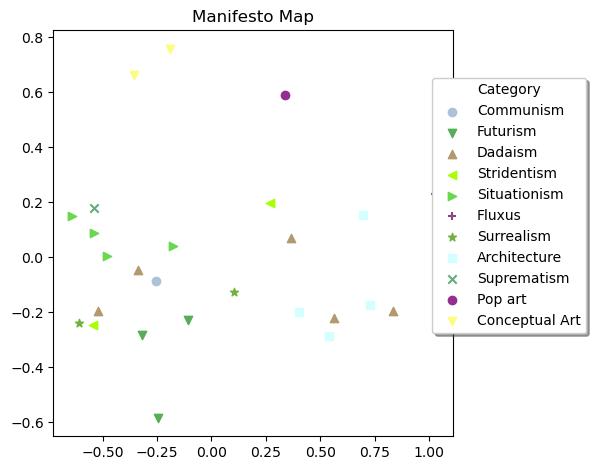

In [9]:
plot_scatter(index_dict, x, y, OFFSET, PATH_PLOT, annotate=ANNOTATE_PLOT)

Use Ward clustering to find out which manifestos are most similar, and plot these out as a Dendogram.

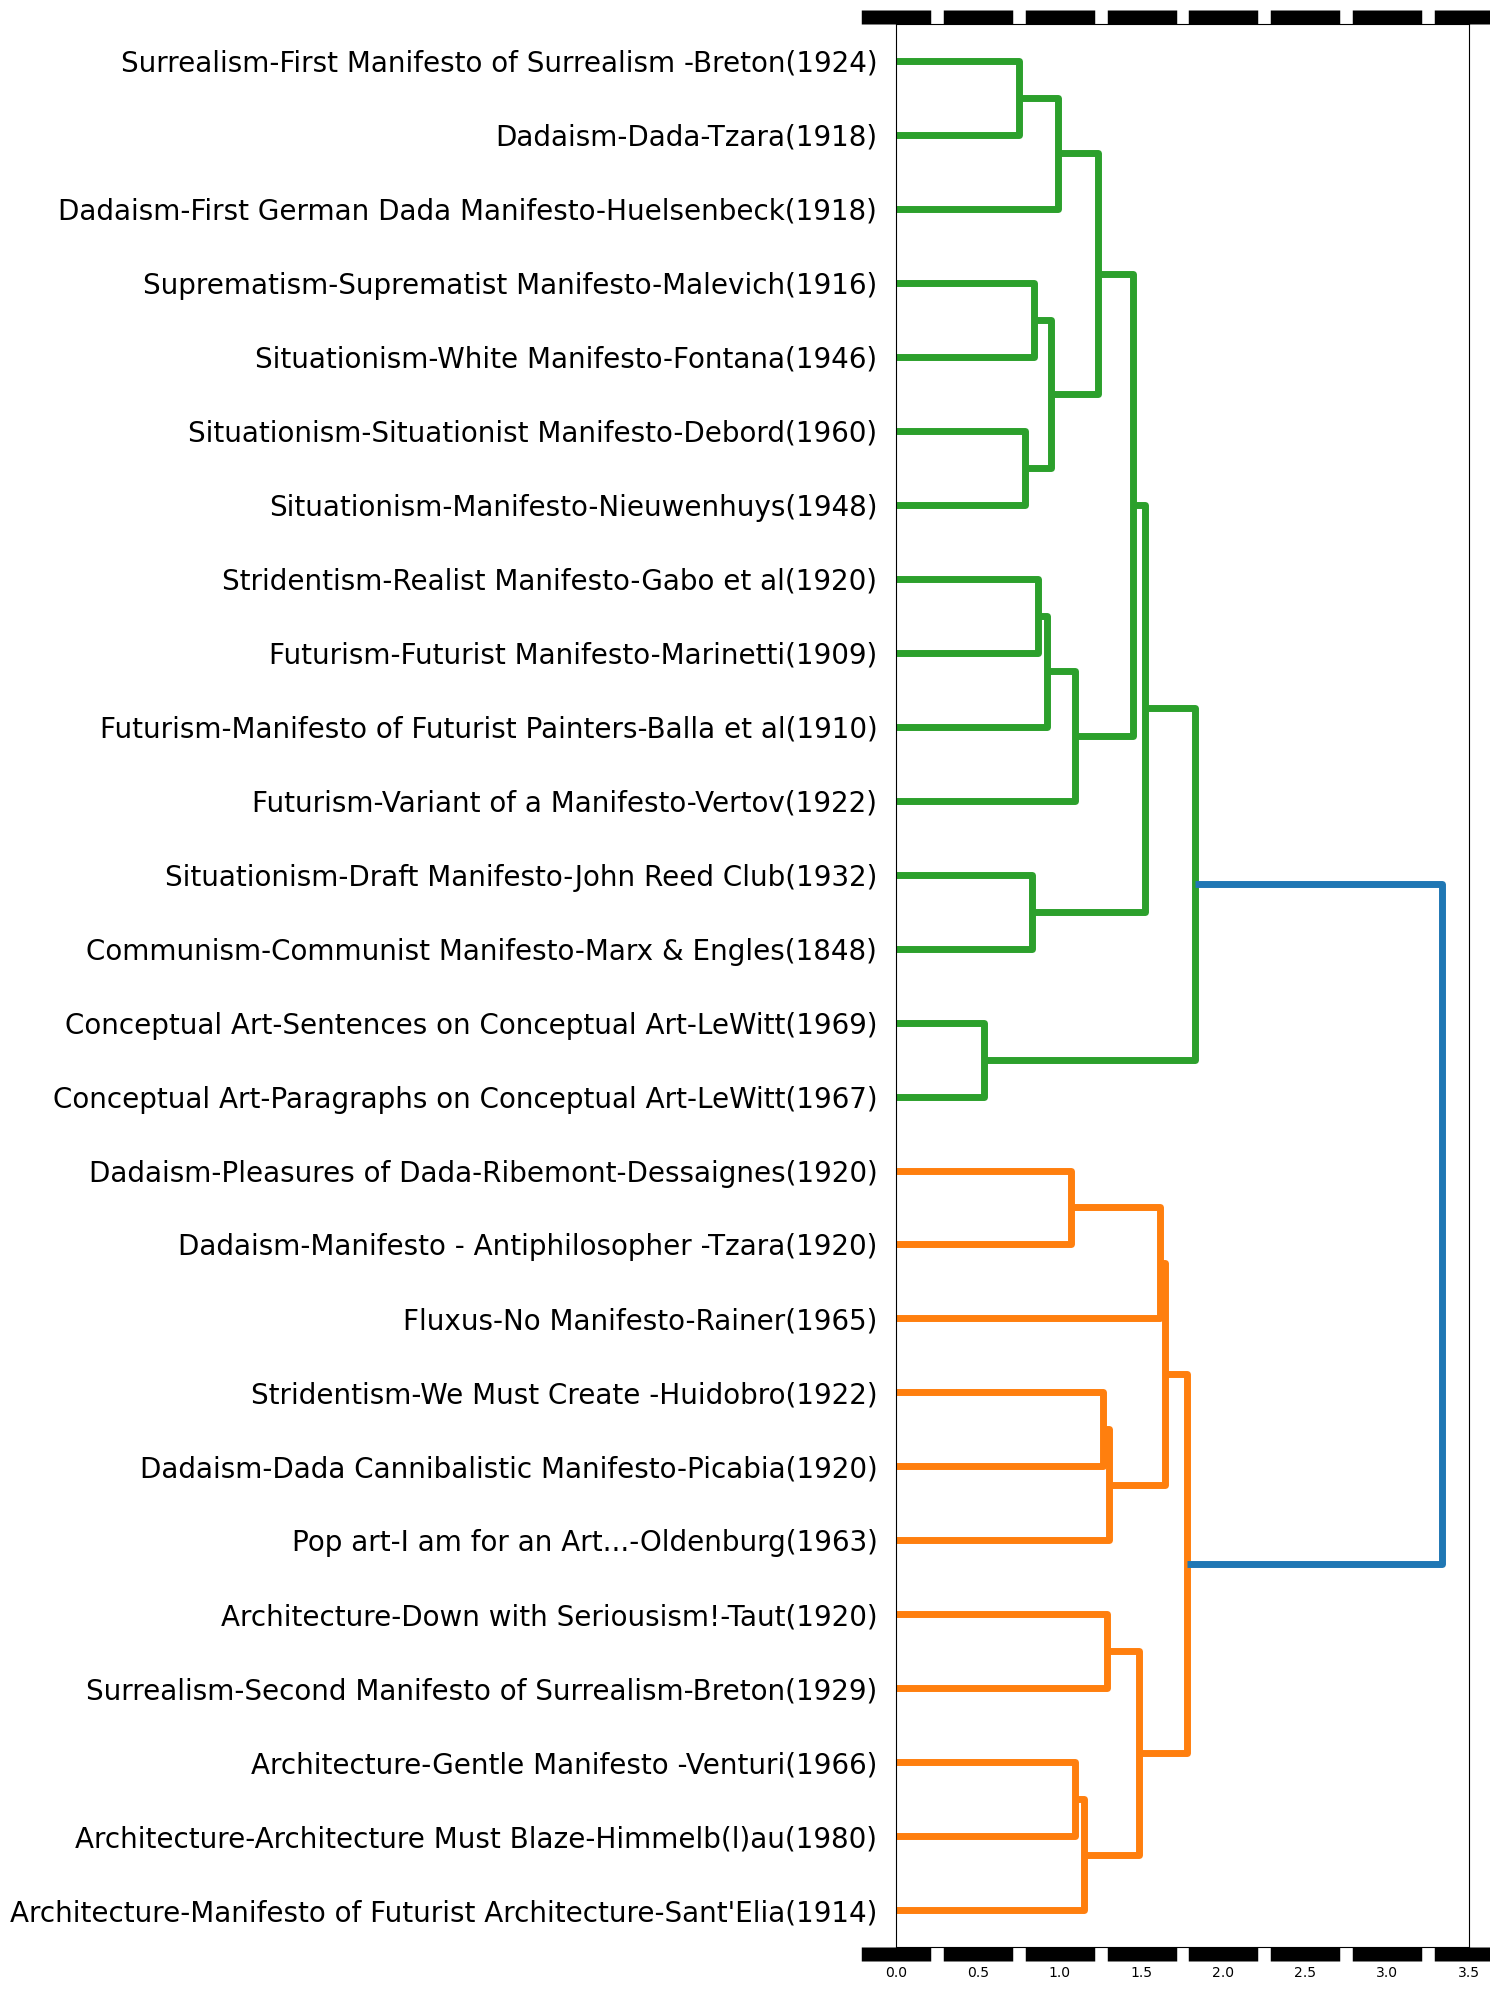

In [10]:
plot_dendogram(simularity_matrix, index_dict, PATH_PLOT)